# Z boson mass


Let's look at a sample of $Z$ boson candidates recorded by CMS in 2011 and published at CERN opendata portal. It comes from DoubleMuon dataset with the following selection applied:

- Both muons are "global" muons
- invariant mass sits in range: 60 GeV < $ M_{\mu\mu}$ < 120 GeV
- |$\eta$| < 2.1 for both muons
- $p_{t}$ > 20 GeV


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
%matplotlib inline

In [2]:
df = pd.read_csv('./Zmumu.csv')
df.shape

(10000, 14)

Let's calculate the invariant mass $M$ of the two muons using the formula

$M = \sqrt{2p_{t}^{1}p_{t}^{2}(\cosh(\eta_{1}-\eta_{2}) - \cos(\phi_{1}-\phi_{2}))}$

In [4]:
df['M'] = np.sqrt(2 * df['pt1'] * df['pt2'] * (np.cosh(df['eta1'] - df['eta2']) - np.cos(df['phi1'] - df['phi2'])))
df.head(10)

,Run,Event,pt1,eta1,phi1,Q1,dxy1,iso1,pt2,eta2,phi2,Q2,dxy2,iso2,M
0,165617,74969122,54.7055,-0.4324,2.5742,1,-0.0745,0.4999,34.2464,-0.9885,-0.4987,-1,0.0712,3.4221,89.885919
1,165617,75138253,24.5872,-2.0522,2.8666,-1,-0.0554,0.0000,28.5389,0.3852,-1.9912,1,0.0515,0.0000,88.812177
2,165617,75887636,31.7386,-2.2595,-1.3323,-1,0.0879,0.0000,30.2344,-0.4684,1.8833,1,-0.0876,0.0000,88.474683
3,165617,75779415,39.7394,-0.7123,-0.3123,1,0.0585,0.0000,48.2790,-0.1956,2.9703,-1,-0.0492,0.0000,90.332429
4,165617,75098104,41.2998,-0.1571,-3.0408,1,-0.0305,1.2280,43.4508,0.5910,-0.0428,-1,0.0442,0.0000,90.515882
5,165617,77255513,38.9425,0.3522,-2.2649,-1,0.0384,0.0000,39.8616,0.2630,0.9183,1,-0.0407,0.0000,78.860090
6,165617,76042048,42.8278,-0.9549,-0.2418,-1,0.0513,0.6926,48.9864,-1.2183,2.8399,1,-0.0545,2.2525,92.362308
7,165617,76661162,17.3593,-1.4809,-1.7046,-1,0.1411,25.9167,19.9872,0.8018,1.8758,1,-0.1022,6.9232,63.756591
8,165617,77076988,38.1511,-0.8702,1.7165,1,-0.0840,0.0000,37.8959,0.5000,-1.8676,-1,0.0652,0.0000,93.118675
9,165617,77459740,51.6437,-1.2153,1.8670,-1,-0.0826,0.0000,42.5626,-1.0076,-0.9362,1,0.0810,0.0000,92.942005


In [5]:
def plot_mass(mass, bins_count=100):
    y, x = np.histogram(mass, bins=bins_count, density=False)
    err = np.sqrt(y)

    fig = plt.figure(figsize=(15,7))
    plt.title('Z mass', fontsize=20)
    plt.xlabel("$m_{\mu\mu}$ [GeV]", fontsize=20)
    plt.ylabel("Number of events", fontsize=20)
    plt.errorbar(x[:-1], y, yerr=err, fmt='o', color='red', ecolor='grey', capthick=0.5, zorder=1, label="data")
    return y, x

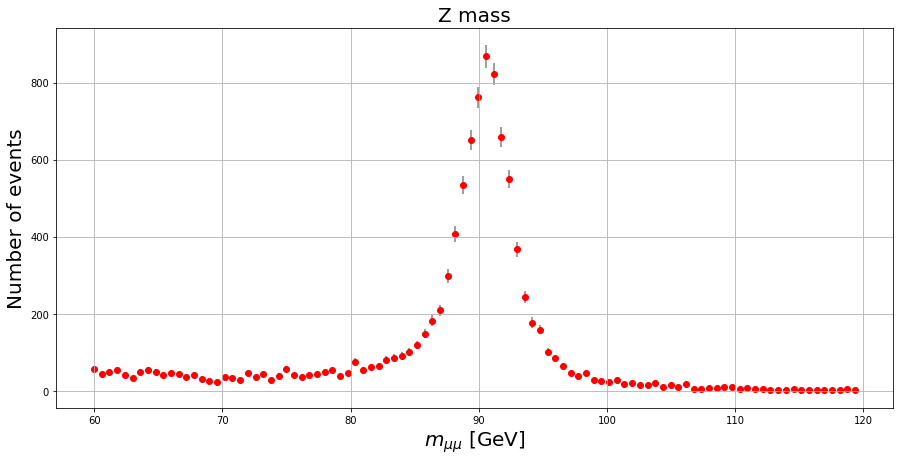

In [7]:
plot_mass(df.M);
plt.grid()

In [8]:
df_sign = df[df['Q1']!=df['Q2']] 
df_isolation = df_sign[(df_sign['iso1']<3) & (df_sign['iso2']<3) & (df_sign['dxy1']<0.2) & (df_sign['dxy2']<0.2)] #
df = df_isolation

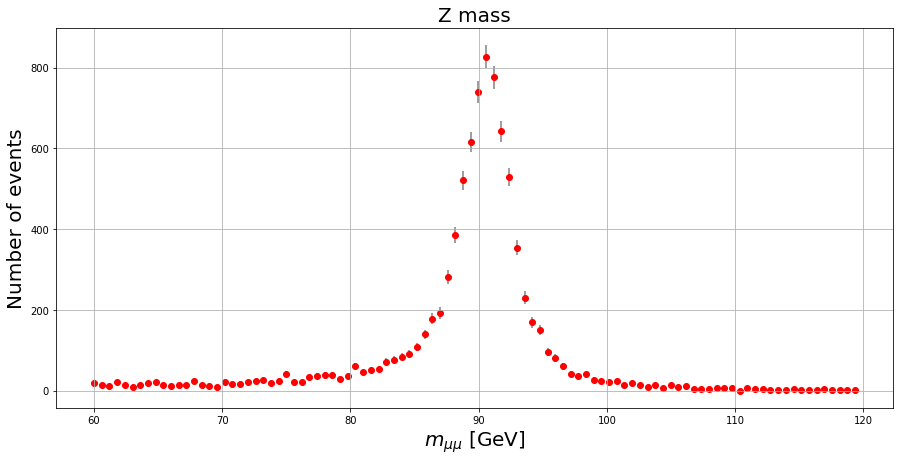

In [9]:
plot_mass(df.M);
plt.grid()

In [10]:
def model_predict(params, X):
    m0, sigma, ampl, bck = params
    return bck + ampl / (sigma * np.sqrt(2 * np.pi)) * np.exp((-1) * (X - m0)**2 / (2 * sigma**2))

In [11]:
def model_loss(params, X, y):
#     y, x = np.histogram(mass, bins=bins_count, density=False)
#     residuals = model_predict(params, (x[1:] + x[:-1])/2) - y 
    residuals = y - model_predict(params, X)
    return np.sum(residuals**2) / len(residuals)

In [12]:
def plot_mass_with_model(params, mass, bins_count=100):
    y, X = plot_mass(mass, bins_count=bins_count)
    X = (X[1:] + X[:-1]) / 2
    error = model_loss(params, X, y)
    plt.plot(X, model_predict(params, X), color='blue', linewidth=3.0, zorder=2, label="fit, loss=%.2f" % error)
    plt.legend(fontsize='x-large')

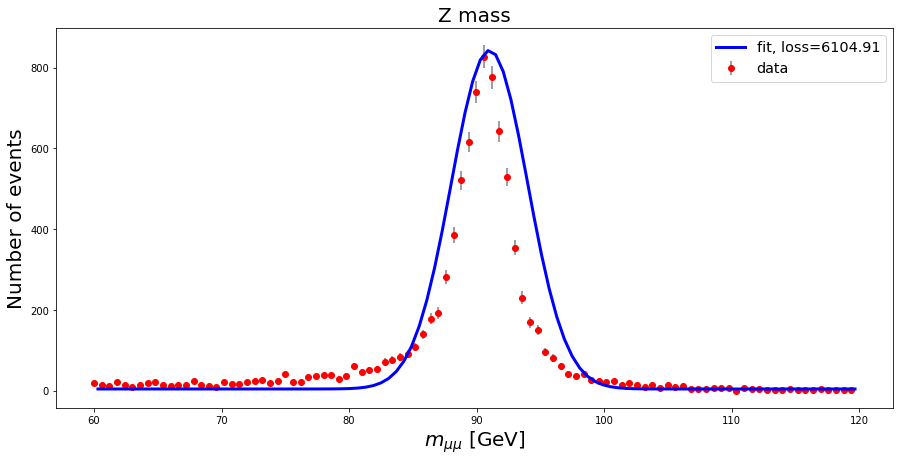

In [13]:
plot_mass_with_model((91, 3.0, 6300, 5), df.M)

In [19]:
from tqdm import tqdm
from skopt import Optimizer

search_space = [(88.0, 93.0), # m0 range
    (1.3, 2.3), # sigma range
    (3400, 4000), # amplitude range
    (0, 60) # bck range
    ]
y, X = np.histogram(df.M, bins=120, density=False)
X = (X[1:] + X[:-1]) / 2
opt = Optimizer(search_space, base_estimator="GP", acq_func="EI", acq_optimizer="lbfgs")

In [20]:
from skopt.utils import create_result
for i in tqdm(range(60)):
    next_x = opt.ask()
    f_val = model_loss(next_x, X, y)
    opt.tell(next_x, f_val)
    
res = create_result(Xi=opt.Xi, yi=opt.yi, space=opt.space,
                         rng=opt.rng, models=opt.models)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.35it/s]


[('m0', 90.69725542645288), ('sigma', 2.119474779902096), ('ampl', 3572), ('bck', 17)]


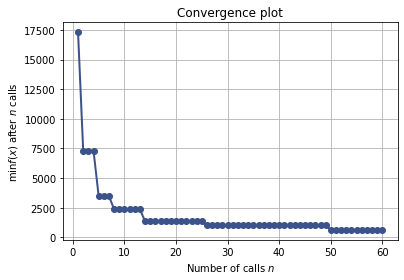

In [21]:
import skopt.plots
skopt.plots.plot_convergence(res)
print (list(zip(["m0", "sigma", "ampl", "bck"], res.x)))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C8A9DF4CC8>,
      dtype=object)

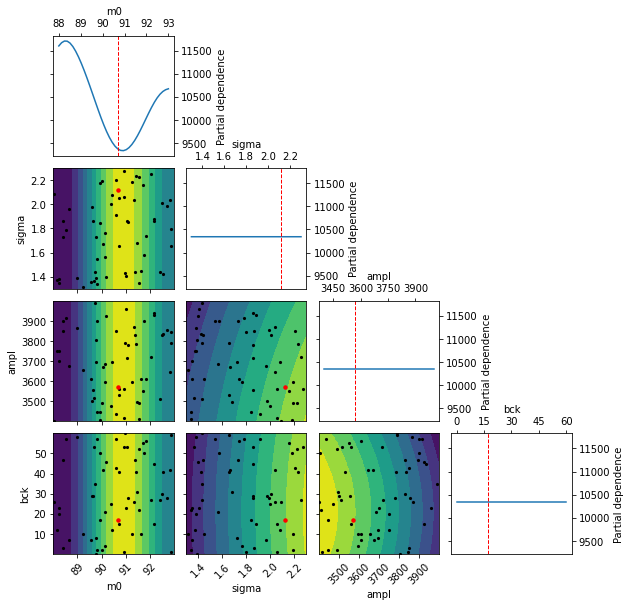

In [22]:
skopt.plots.plot_objective(res, dimensions=['m0', 'sigma', 'ampl', 'bck'])

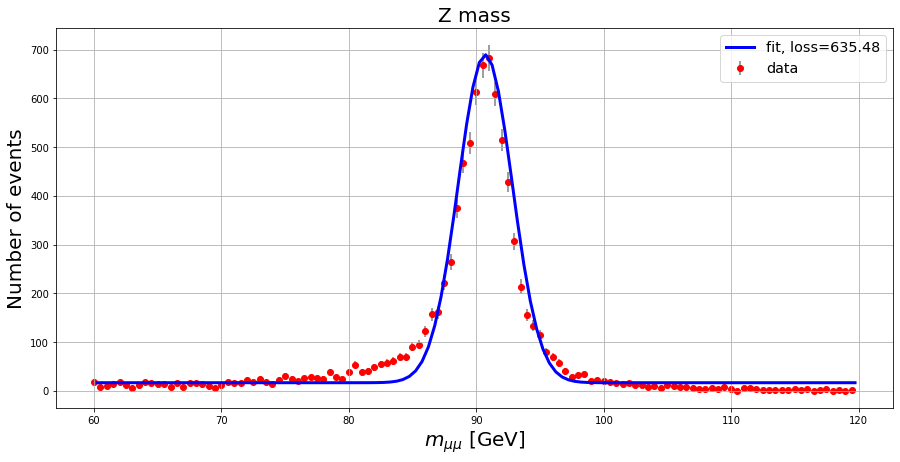

In [23]:
plot_mass_with_model(res.x, df.M, bins_count=120)
plt.grid()
#plt.xlim(0,100)
#plt.ylim(-5,20)